<a href="https://colab.research.google.com/github/olwflynn/Learning/blob/master/PhysicsModelInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install dependencies

!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common \
    xvfb

!apt-get install -y patchelf

!pip install gym==0.21.0 free-mujoco-py mujoco torch

!pip install colabgymrender==1.0.2
!pip install xvfbwrapper
!pip install imageio==2.4.1


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  libgl1-mesa-glx libglew-dev libglew2.0 libosmesa6 libosmesa6-dev xvfb
0 upgraded, 6 newly installed, 0 to remove and 21 not upgraded.
Need to get 3,701 kB of archives.
After this operation, 14.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew2.0 amd64 2.0.0-5 [140 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic

In [2]:
#@title Import dependencies

import mujoco_py
import gym
import numpy as np
import torch
import pandas as pd

Compiling /usr/local/lib/python3.8/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.8/dist-packages/mujoco_py/cymj.pyx
running build_ext
building 'mujoco_py.cymj' extension
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder/temp.linux-x86_64-3.8
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder/temp.linux-x86_64-3.8/usr
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder/temp.linux-x86_64-3.8/usr/local
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuextensionbuilder/temp.linux-x86_64-3.8/usr/local/lib
creating /usr/local/lib/python3.8/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_38_linuxcpuexten

TODO (each task should be able to be completed in an hour):
- create a plot with a constant prediction - DONE
- create a naive deterministic predictor - DONE
- create trained predictor (pytorch logistic regression, nn and pyro) - DONE
- create dashboard to output error rates - DONE
- add readme for information and physics
- write brief medium post linking to collab notebook
- write readme for github learning directory

In [3]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 62.3 MB/s eta 0:00:00


In [9]:
#@title Setup environment for inverted double pendulum
from colabgymrender.recorder import Recorder

directory = './video'
env = gym.make("InvertedDoublePendulum-v2")
env = Recorder(env, directory, fps=30)

In [10]:
# get forecast error given a predicted trajectory and observations
import numpy as np

def forecast_error(X_obs, preds):
    
    rmse = np.sqrt(sum(np.square(X_obs - preds)))
    
    return rmse

In [24]:
import time

def create_rows_for_episode(ep_num, time_delay=0):
  env.reset()
  for _ in range(100):
    try:
      observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    except ValueError:
      observation, reward, terminated, info = env.step(env.action_space.sample())
    time.sleep(time_delay)
    features = np.array(observation[:8]).reshape(1, 8)
    if _ == 0:
      rows_for_ep = features
    else:
      rows_for_ep = np.concatenate((rows_for_ep, features), axis=0)
    if terminated:
      labels = np.array(range(_, -1,-1)).reshape(_+1, 1)
      ep_num_arr = np.array([ep_num for i in range(len(labels))]).reshape(_+1, 1)
      assert len(labels) == len(rows_for_ep)
      rows_for_ep = np.concatenate((rows_for_ep, labels), axis=1)
      rows_for_ep = np.concatenate((rows_for_ep, ep_num_arr), axis=1)
      # print(len(rows_for_ep), type(rows_for_ep))
      return rows_for_ep

In [27]:
# create a dataset with positions of the pendulum as features and time to terminate as label

import pandas as pd
import matplotlib.pyplot as plt

def run_episodes(num_eps, time_delay, model=None):

    columns = []
    for i in range(8):
      columns.append(f'feature_{i}')
    columns.append('time_to_terminate')
    columns.append('ep_num')

    #create array
    num_episodes = num_eps
    for j in range(num_episodes):
      episode_rows = create_rows_for_episode(j, time_delay=time_delay)
      if j == 0:
        arr = episode_rows
      else:
        arr = np.concatenate([arr, episode_rows], axis=0)
    env.close()

    df = pd.DataFrame(arr, columns=columns)
    # print(df.head())
    # print(df.describe())
    # print(df.info())

    ep_split_df = [df[df['ep_num']==i] for i in range(1)]
    print(ep_split_df[0])
    num_features = 8
    num_plots = num_features+1
    if model:
      num_plots+=1
    fig, axs = plt.subplots(num_plots, figsize=(18, 18))
    plt.suptitle('Episode plots')
    for i in range(num_features):
      for el in ep_split_df:
        ep = el['ep_num'].values[0]
        axs[i].plot(el[f'feature_{i}'], label=f'episode_{int(ep)}')
        axs[i].set_title(f'feature_{i}', fontsize='small')
    axs[8].plot(ep_split_df[0]['time_to_terminate'], label='time_to_terminate')
    axs[8].set_title('time_to_terminate', fontsize='small')
    if model:
      input_tensor = torch.tensor(df.values[:,:8], dtype=dtype, device=device).view(len(df), -1)
      preds = model(input_tensor)
      axs[9].plot(preds.cpu().detach().numpy(), label='predictions')
      axs[9].set_title('predictions', fontsize='small')
      ep_error = forecast_error(ep_split_df[0]['time_to_terminate'], preds.cpu().detach().numpy().reshape(len(df),))
      print('Predictions: \n', preds.cpu().detach().numpy())
      print('RMSE of episode: \n', ep_error)
    # plt.legend(loc='right')
    plt.show()

    return df

In [13]:
#@title Load model from Gdrive

from google.colab import drive
from os.path import join

ROOT = '/content/drive'
drive.mount(ROOT)

PROJ = 'MyDrive/LearningPhysics/Models'
PROJECT_PATH = join(ROOT, PROJ)

print('Connected to Gdrive path: \n', PROJECT_PATH)

Mounted at /content/drive
Connected to Gdrive path: 
 /content/drive/MyDrive/LearningPhysics/Models


In [17]:
#@title Create model class and load models params from /models directory
from torch import nn

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device: \n', device)

class DenseNet(nn.Module):
  def __init__(self):
    super(DenseNet, self).__init__()
    self.layer1 = nn.Linear(8,20)
    self.layer2 = nn.Linear(20,1)
    self.softplus = nn.Softplus()
  
  def forward(self, X):
    hidden1 = self.layer1(X)
    hidden2 = self.layer2(hidden1)

    output = self.softplus(hidden2)
    return output

MODEL_PATH = '/models/10000eps_DenseNet_10000epochs.pt'

loaded_dense_net = DenseNet()
loaded_dense_net.load_state_dict(torch.load(PROJECT_PATH+MODEL_PATH))
loaded_dense_net.to(device)

print('Loaded DenseNet model to device')

Using device: 
 cuda
Loaded DenseNet model to device


using v2 environment rather than v4
using v2 environment rather than v4
using v2 environment rather than v4
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.023182   0.050073  -0.052099   0.998746   0.998642  -2.334957   
1  -0.274790   0.499431  -0.593240   0.866353   0.805026  -1.792219   
2  -0.538456   0.866508  -0.894067   0.499163   0.447934  -2.718598   

   feature_6  feature_7  time_to_terminate  ep_num  
0   4.221935  -5.397051                2.0     0.0  
1   3.858458  -5.051796                1.0     0.0  
2   5.771244  -3.799677                0.0     0.0  
Predictions: 
 [[5.0193415 ]
 [1.7424552 ]
 [0.00985629]]
RMSE of episode: 
 3.1093021469591857


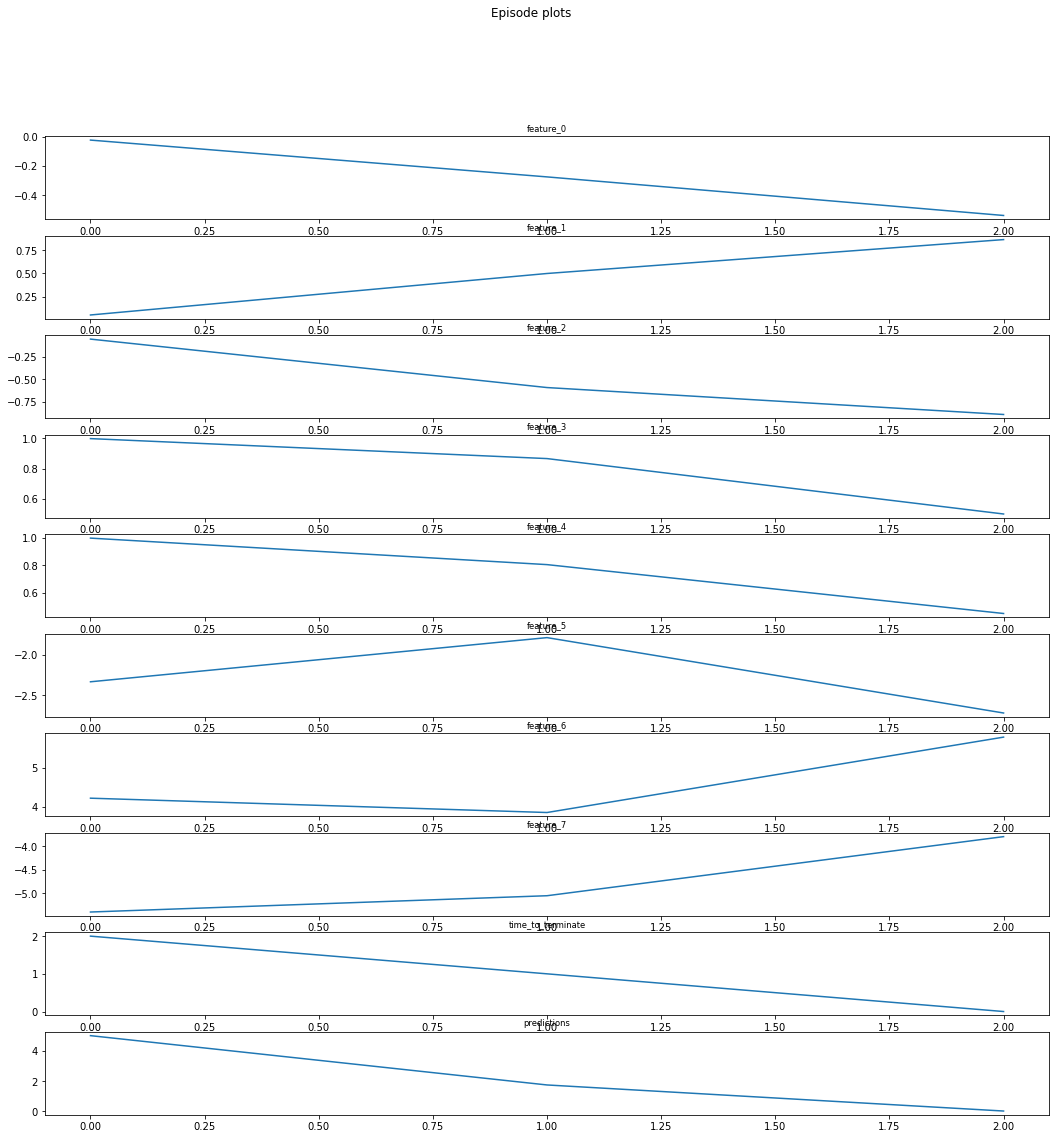

In [36]:
ep_df = run_episodes(1, 0.1, model=loaded_dense_net)

In [37]:
# Play the video
env.play()


100%|██████████| 7/7 [00:00<00:00, 228.18it/s]
